In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=100 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [27]:
y.shape

(144, 2)

In [28]:
x_para_train, x_para_test, x_train, x_test, y_train, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [29]:
x_train.shape

(129, 2, 55, 1)

In [30]:
y_train.shape

(129, 2)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 100)   500         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 100)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2700)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
6/6 [==============================] - 3s 6ms/step - loss: 0.5597 - rmse: 0.7481 - lr: 0.0010
Epoch 2/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.2371 - rmse: 0.4869 - lr: 0.0010
Epoch 3/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1216 - rmse: 0.3487 - lr: 0.0010
Epoch 4/5000
6/6 [==============================] - 0s 4ms/step - loss: 0.1317 - rmse: 0.3629 - lr: 0.0010
Epoch 5/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1085 - rmse: 0.3294 - lr: 0.0010
Epoch 6/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1004 - rmse: 0.3169 - lr: 0.0010
Epoch 7/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0946 - rmse: 0.3076 - lr: 0.0010
Epoch 8/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0930 - rmse: 0.3049 - lr: 0.0010
Epoch 9/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0890 - rmse: 0.2983 - lr: 0.0010
Epoch 10/5000
6/6 [==================

Epoch 77/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0169 - rmse: 0.1298 - lr: 0.0010
Epoch 78/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0152 - rmse: 0.1232 - lr: 0.0010
Epoch 79/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0187 - rmse: 0.1366 - lr: 0.0010
Epoch 80/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0149 - rmse: 0.1221 - lr: 0.0010
Epoch 81/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0148 - rmse: 0.1217 - lr: 0.0010
Epoch 82/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0185 - rmse: 0.1358 - lr: 0.0010
Epoch 83/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0127 - rmse: 0.1126 - lr: 0.0010
Epoch 84/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1236 - lr: 0.0010
Epoch 85/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0149 - rmse: 0.1221 - lr: 0.0010
Epoch 86/5000
6/6 [=========

6/6 [==============================] - 0s 6ms/step - loss: 0.0077 - rmse: 0.0875 - lr: 0.0010
Epoch 153/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0161 - rmse: 0.1267 - lr: 0.0010
Epoch 154/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0111 - rmse: 0.1054 - lr: 0.0010
Epoch 155/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0122 - rmse: 0.1103 - lr: 0.0010
Epoch 156/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0125 - rmse: 0.1120 - lr: 0.0010
Epoch 157/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0113 - rmse: 0.1063 - lr: 0.0010
Epoch 158/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 0.0010
Epoch 159/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 0.0010
Epoch 160/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0090 - rmse: 0.0951 - lr: 0.0010
Epoch 161/5000
6/6 [==============

6/6 [==============================] - 0s 6ms/step - loss: 0.0055 - rmse: 0.0739 - lr: 0.0010
Epoch 228/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0038 - rmse: 0.0619 - lr: 0.0010
Epoch 229/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0048 - rmse: 0.0693 - lr: 0.0010
Epoch 230/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0048 - rmse: 0.0690 - lr: 0.0010
Epoch 231/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0560 - lr: 0.0010
Epoch 232/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0553 - lr: 0.0010
Epoch 233/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0514 - lr: 0.0010
Epoch 234/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0553 - lr: 0.0010
Epoch 235/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0047 - rmse: 0.0683 - lr: 0.0010
Epoch 236/5000
6/6 [==============

Epoch 302/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0394 - lr: 0.0010
Epoch 303/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0589 - lr: 0.0010
Epoch 304/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0348 - lr: 0.0010
Epoch 305/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0020 - rmse: 0.0448 - lr: 0.0010
Epoch 306/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.9566e-04 - rmse: 0.0264 - lr: 0.0010
Epoch 307/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0416 - lr: 0.0010
Epoch 308/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0393 - lr: 0.0010
Epoch 309/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0386 - lr: 0.0010
Epoch 310/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0014 - rmse: 0.0378 - lr: 0.0010
Epoch 311/5000


6/6 [==============================] - 0s 6ms/step - loss: 1.4975e-04 - rmse: 0.0122 - lr: 0.0010
Epoch 376/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8657e-04 - rmse: 0.0137 - lr: 0.0010
Epoch 377/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5202e-04 - rmse: 0.0123 - lr: 0.0010
Epoch 378/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7254e-04 - rmse: 0.0131 - lr: 0.0010
Epoch 379/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0911e-04 - rmse: 0.0145 - lr: 0.0010
Epoch 380/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.5017e-04 - rmse: 0.0158 - lr: 0.0010
Epoch 381/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3727e-04 - rmse: 0.0117 - lr: 0.0010
Epoch 382/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0653e-04 - rmse: 0.0144 - lr: 0.0010
Epoch 383/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.8576e-04 - rmse: 0.0169 - lr: 0.001

6/6 [==============================] - 0s 7ms/step - loss: 1.1494e-04 - rmse: 0.0107 - lr: 0.0010
Epoch 448/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.2623e-04 - rmse: 0.0112 - lr: 0.0010
Epoch 449/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.0517e-04 - rmse: 0.0103 - lr: 0.0010
Epoch 450/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.5569e-05 - rmse: 0.0093 - lr: 0.0010
Epoch 451/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1233e-04 - rmse: 0.0106 - lr: 0.0010
Epoch 452/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.3907e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 453/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.3146e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 454/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0794e-04 - rmse: 0.0104 - lr: 0.0010
Epoch 455/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1399e-04 - rmse: 0.0107 - lr: 0.001

6/6 [==============================] - 0s 6ms/step - loss: 5.5513e-04 - rmse: 0.0236 - lr: 0.0010
Epoch 520/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.1054e-04 - rmse: 0.0285 - lr: 0.0010
Epoch 521/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.7889e-04 - rmse: 0.0261 - lr: 0.0010
Epoch 522/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.2997e-04 - rmse: 0.0305 - lr: 0.0010
Epoch 523/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0473 - lr: 0.0010
Epoch 524/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0352 - lr: 0.0010
Epoch 525/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0541 - lr: 0.0010
Epoch 526/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0316 - lr: 0.0010
Epoch 527/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0324 - lr: 0.0010
Epoch 528/5000
6/6

6/6 [==============================] - 0s 6ms/step - loss: 3.5001e-05 - rmse: 0.0059 - lr: 5.0000e-04
Epoch 590/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2986e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 591/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6890e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 592/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2995e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 593/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.3164e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 594/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.1806e-05 - rmse: 0.0056 - lr: 5.0000e-04
Epoch 595/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5193e-05 - rmse: 0.0059 - lr: 5.0000e-04
Epoch 596/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.7560e-05 - rmse: 0.0052 - lr: 5.0000e-04
Epoch 597/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.258

6/6 [==============================] - 0s 6ms/step - loss: 2.1233e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 660/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8984e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 661/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7236e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 662/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.9429e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 663/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1214e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 664/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1994e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 665/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1234e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 666/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0113e-05 - rmse: 0.0045 - lr: 5.0000e-04
Epoch 667/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.617

6/6 [==============================] - 0s 7ms/step - loss: 2.5053e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 730/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.0534e-05 - rmse: 0.0090 - lr: 5.0000e-04
Epoch 731/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.2048e-05 - rmse: 0.0079 - lr: 5.0000e-04
Epoch 732/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.5108e-05 - rmse: 0.0067 - lr: 5.0000e-04
Epoch 733/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.5137e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 734/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.9182e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 735/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.9623e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 736/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.3907e-05 - rmse: 0.0049 - lr: 5.0000e-04
Epoch 737/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.585

6/6 [==============================] - 0s 6ms/step - loss: 1.0716e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 800/5000
6/6 [==============================] - 0s 7ms/step - loss: 9.1931e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 801/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0901e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 802/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3348e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 803/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.9746e-06 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 804/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1626e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 805/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8876e-05 - rmse: 0.0043 - lr: 5.0000e-04
Epoch 806/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1345e-05 - rmse: 0.0046 - lr: 5.0000e-04
Epoch 807/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.377

6/6 [==============================] - 0s 6ms/step - loss: 3.7877e-04 - rmse: 0.0195 - lr: 5.0000e-04
Epoch 870/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1834e-04 - rmse: 0.0148 - lr: 5.0000e-04
Epoch 871/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.8220e-04 - rmse: 0.0313 - lr: 5.0000e-04
Epoch 872/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0327 - lr: 5.0000e-04
Epoch 873/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.2227e-04 - rmse: 0.0249 - lr: 5.0000e-04
Epoch 874/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.0360e-04 - rmse: 0.0224 - lr: 5.0000e-04
Epoch 875/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.2091e-04 - rmse: 0.0149 - lr: 5.0000e-04
Epoch 876/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2709e-04 - rmse: 0.0181 - lr: 5.0000e-04
Epoch 877/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.4616e-0

Epoch 938/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4996e-05 - rmse: 0.0039 - lr: 2.5000e-04
Epoch 939/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2486e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 940/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4756e-05 - rmse: 0.0038 - lr: 2.5000e-04
Epoch 941/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2132e-05 - rmse: 0.0035 - lr: 2.5000e-04
Epoch 942/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1334e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 943/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.1337e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 944/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.0393e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 945/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0791e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 946/5000
6/6 [==============================] - 0s 6ms/ste

Epoch 1008/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.8821e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1009/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.0574e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1010/5000
6/6 [==============================] - 0s 7ms/step - loss: 9.2946e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1011/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.3561e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1012/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.2222e-06 - rmse: 0.0023 - lr: 2.5000e-04
Epoch 1013/5000
6/6 [==============================] - 0s 7ms/step - loss: 9.1293e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1014/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.9455e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1015/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.8247e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1016/5000
6/6 [==============================] - 0

6/6 [==============================] - 0s 7ms/step - loss: 8.2980e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1078/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.6179e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1079/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.7881e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1080/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.2854e-06 - rmse: 0.0027 - lr: 2.5000e-04
Epoch 1081/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.4019e-06 - rmse: 0.0023 - lr: 2.5000e-04
Epoch 1082/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.4894e-06 - rmse: 0.0027 - lr: 2.5000e-04
Epoch 1083/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.8476e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1084/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.1112e-06 - rmse: 0.0023 - lr: 2.5000e-04
Epoch 1085/5000
6/6 [==============================] - 0s 7ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 6.6522e-06 - rmse: 0.0026 - lr: 2.5000e-04
Epoch 1147/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3854e-05 - rmse: 0.0037 - lr: 2.5000e-04
Epoch 1148/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.6441e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1149/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0828e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1150/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0399e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1151/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0907e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1152/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.5272e-06 - rmse: 0.0027 - lr: 2.5000e-04
Epoch 1153/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.7154e-06 - rmse: 0.0031 - lr: 2.5000e-04
Epoch 1154/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 5.3344e-06 - rmse: 0.0023 - lr: 1.2500e-04
Epoch 1215/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.5887e-06 - rmse: 0.0021 - lr: 1.2500e-04
Epoch 1216/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.9704e-06 - rmse: 0.0022 - lr: 1.2500e-04
Epoch 1217/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.5768e-06 - rmse: 0.0021 - lr: 1.2500e-04
Epoch 1218/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.2720e-06 - rmse: 0.0023 - lr: 1.2500e-04
Epoch 1219/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.5358e-06 - rmse: 0.0027 - lr: 1.2500e-04
Epoch 1220/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.6612e-06 - rmse: 0.0029 - lr: 1.2500e-04
Epoch 1221/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.6172e-06 - rmse: 0.0024 - lr: 1.2500e-04
Epoch 1222/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 4.8074e-06 - rmse: 0.0022 - lr: 1.2500e-04
Epoch 1284/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.3425e-06 - rmse: 0.0021 - lr: 1.2500e-04
Epoch 1285/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.4465e-06 - rmse: 0.0021 - lr: 1.2500e-04
Epoch 1286/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.2605e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1287/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.3484e-06 - rmse: 0.0025 - lr: 1.2500e-04
Epoch 1288/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.9158e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1289/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.7748e-06 - rmse: 0.0026 - lr: 1.2500e-04
Epoch 1290/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.4030e-06 - rmse: 0.0023 - lr: 1.2500e-04
Epoch 1291/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 1.2540e-05 - rmse: 0.0035 - lr: 1.2500e-04
Epoch 1353/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.6946e-05 - rmse: 0.0041 - lr: 1.2500e-04
Epoch 1354/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.3029e-05 - rmse: 0.0036 - lr: 1.2500e-04
Epoch 1355/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.6215e-06 - rmse: 0.0029 - lr: 1.2500e-04
Epoch 1356/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.2591e-06 - rmse: 0.0027 - lr: 1.2500e-04
Epoch 1357/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.6936e-06 - rmse: 0.0029 - lr: 1.2500e-04
Epoch 1358/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.8628e-06 - rmse: 0.0031 - lr: 1.2500e-04
Epoch 1359/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.7675e-06 - rmse: 0.0030 - lr: 1.2500e-04
Epoch 1360/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 3.2353e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1421/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5663e-06 - rmse: 0.0019 - lr: 6.2500e-05
Epoch 1422/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5418e-06 - rmse: 0.0019 - lr: 6.2500e-05
Epoch 1423/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.6515e-06 - rmse: 0.0019 - lr: 6.2500e-05
Epoch 1424/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.0537e-06 - rmse: 0.0020 - lr: 6.2500e-05
Epoch 1425/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.3515e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1426/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.1891e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1427/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.1927e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1428/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 3.4073e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1490/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.9503e-06 - rmse: 0.0017 - lr: 6.2500e-05
Epoch 1491/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2773e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1492/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.8335e-06 - rmse: 0.0017 - lr: 6.2500e-05
Epoch 1493/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.7441e-06 - rmse: 0.0017 - lr: 6.2500e-05
Epoch 1494/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.9273e-06 - rmse: 0.0020 - lr: 6.2500e-05
Epoch 1495/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.0980e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1496/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.1396e-06 - rmse: 0.0020 - lr: 6.2500e-05
Epoch 1497/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 4.7630e-06 - rmse: 0.0022 - lr: 6.2500e-05
Epoch 1559/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.1426e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1560/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5981e-06 - rmse: 0.0019 - lr: 6.2500e-05
Epoch 1561/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2889e-06 - rmse: 0.0018 - lr: 6.2500e-05
Epoch 1562/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6691e-06 - rmse: 0.0016 - lr: 6.2500e-05
Epoch 1563/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.9430e-06 - rmse: 0.0020 - lr: 6.2500e-05
Epoch 1564/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.0810e-06 - rmse: 0.0025 - lr: 6.2500e-05
Epoch 1565/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.0909e-06 - rmse: 0.0020 - lr: 6.2500e-05
Epoch 1566/5000
6/6 [==============================] - 0s 6ms/step - los

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:04.988822


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_I_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

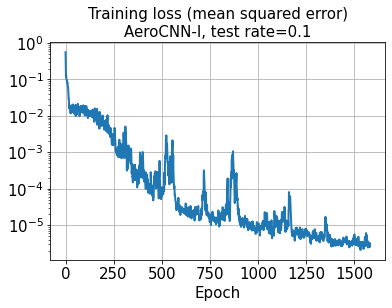

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

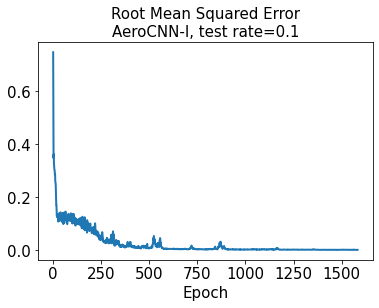

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

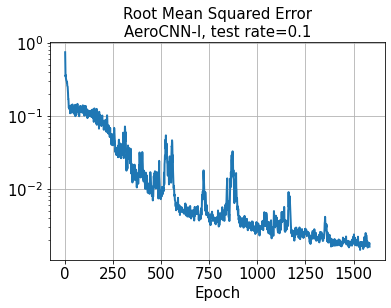

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-I, test rate={}'.format(test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate([x_train, x_para_train], y_train)

5/5 [==============================] - 0s 12ms/step - loss: 3.0019e-06 - rmse: 0.0017


In [44]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 61ms/step - loss: 6.4703e-05 - rmse: 0.0080


In [45]:
decoded_train = model.predict([x_train, x_para_train])
decoded_test = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 15ms/step


In [46]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_I_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_test_abs = np.abs(decoded_test - y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0020283684312435014


In [51]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.00929669842820455


In [52]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.024867560531132586


In [53]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.0018102598523845664


In [54]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.06566340876754935


In [55]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.009064567623944886


In [56]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [58]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [59]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [60]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [61]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

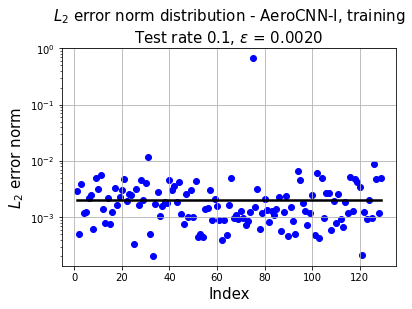

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

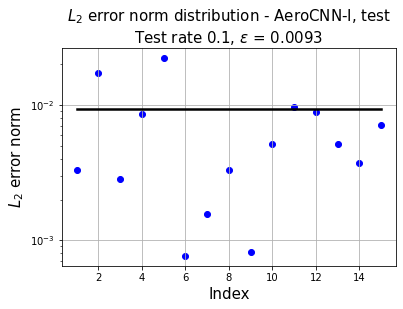

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

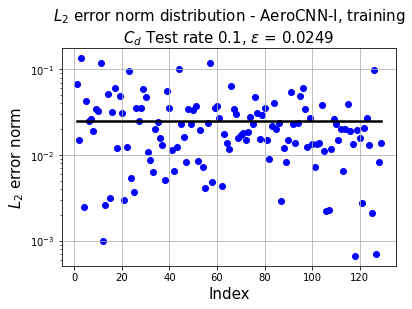

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

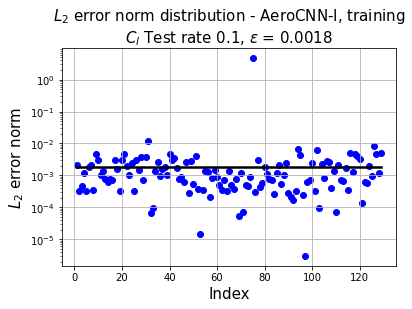

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

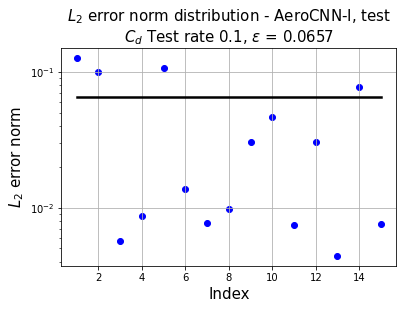

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

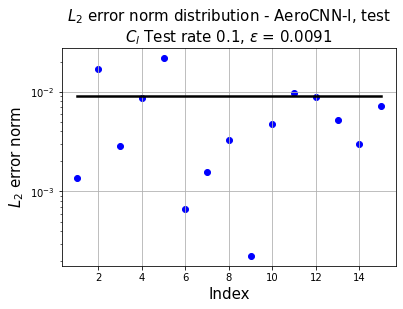

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()